In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve, curve_fit
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.interpolate import interp1d, interp2d
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.pyplot import cm 

In [2]:
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
mdot = 1.99e33 #grams
G = 6.67259e-8 #cgs
EiCO = 850 #K
EiCO2 = 2000
EiH2O = 5800
mCO = 28*mH
mCO2 = 44*mH
mH2O = 18*mH
Ni = 10**15 #cm^-2 number of sites
au2cm = 1.496e13
nCO = 1.5e-4
nCO2 = 0.3e-4
nH2O = 0.9e-4
SB = 5.6704e-5
Ldot = 3.839e33
rsun = 7e10
yr = 3.154e7
Myr = 3.154e13

In [3]:
drtau_age = Myr
M_star = 0.8*mdot
alpha = 1e-3

In [4]:

def disk_temperature(r):
    T0 = 121.389793367
    T = T0*(r**(-3./7))
    return T

def sigma(r):
    r_c = 20
    gamma = 1.07
    sigma0 = 315.
    sigma = sigma0*((r/r_c)**(-gamma))*np.exp(-(r/r_c)**(2-gamma))
    return sigma

def density(r):
    T = disk_temperature(r)
    omega = np.sqrt((G*M_star)/(r*au2cm)**3)
    cs = np.sqrt((boltzmann*T)/(2.35*mH))
    H = cs/omega
    
    rhoGas =sigma(r)/H
    
    return rhoGas

In [5]:
def tau_early_grow(r,t):
    omega = np.sqrt((G*M_star)/(r*au2cm)**3)
    a_big = amax(r,t)[0]
    a_little = 1e-5
    
    
    fd = 1e-2
    
    t_early_grow = (0.033*alpha**-0.63/(omega*fd))*np.log(a_big/a_little)
    
    return t_early_grow


def amax(r,current_age):
    mstar = M_star
    omega = np.sqrt((G*mstar)/(r*au2cm)**3)
    T = disk_temperature(r)
    v_kep = omega*(r*au2cm)
    cs = np.sqrt((boltzmann*T)/(2.35*mH))
    v0 = cs**2/(2*v_kep)
    rho_part = 2.
    rhoGas = density(r)    
    age = current_age
    
    lambda_mfp = 1./((rhoGas/(2.3*mH))*np.pi*(3e-8)**2)
    regime = (9*lambda_mfp)/4.
    
    size = (sigma(r)*r*au2cm)/2.5/age/v0/rho_part
    tau_stop = ((rho_part*size)/(rhoGas*cs))*omega
    
    return size, tau_stop


def fd(r,current_age):
    rho_part = 2.
    s = amax(r,current_age)[0]
    St = amax(r,current_age)[1]
    
    omega = np.sqrt((G*M_star)/(r*au2cm)**3)
    T = disk_temperature(r)
    cs= np.sqrt((boltzmann*T)/(2.35*mH))
    H = cs/omega
    
    current_age = current_age - tau_early_grow(r,current_age)
    
    if current_age < 0.:
        fd = 1e-2
    
    else:
    
        Hd = H*np.sqrt(alpha/(alpha+St))
        delta_v = np.sqrt(3.*alpha*St)*cs
        fd = (8.*s*rho_part*Hd)/(3.*current_age*sigma(r)*0.55*delta_v)
    
    if fd > 1e-2:
        fd = 1e-2
    
    #account for size distribution
    fd *=1.3
    
    return fd

In [23]:
radius_array = np.linspace(1,150,100)
fd_calc = []

for r in radius_array:
    fd_calc.append(fd(r,drtau_age))
    
print(np.average(fd_calc)) #average dust-to-gas ratio in outer disk

0.000661180089341988


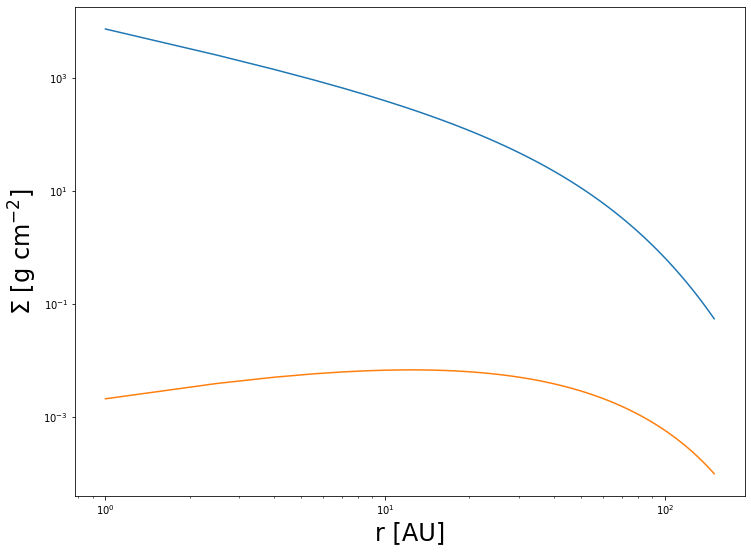

Text(0, 0.5, 'Dust to gas ratio')

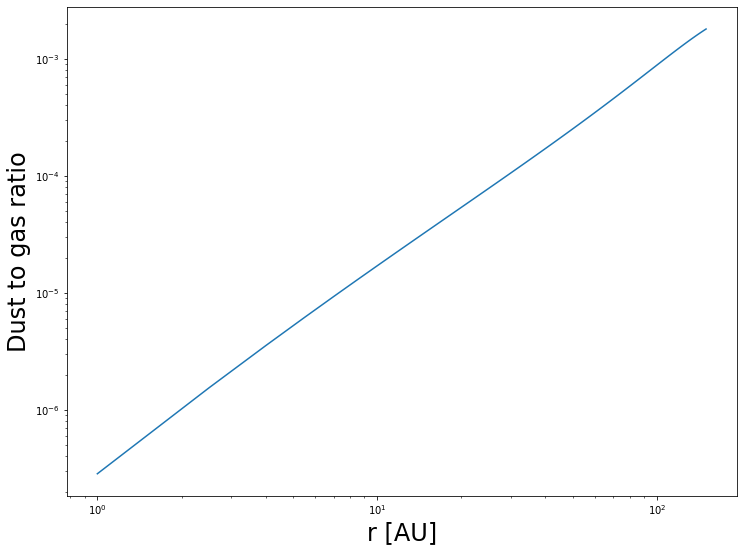

In [24]:
fig = plt.figure(1,figsize=(12,9))
plt.loglog(radius_array, sigma(radius_array))
plt.loglog(radius_array,sigma(radius_array)*fd_calc)
plt.xlabel(r'r [AU]', fontsize=24)
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]', fontsize=24)
plt.show()

fig = plt.figure(1,figsize=(12,9))
plt.loglog(radius_array, fd_calc)
plt.xlabel(r'r [AU]', fontsize=24)
plt.ylabel('Dust to gas ratio', fontsize=24)